# Segmentation on testicular germ cell tumors data 

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar 23 19:13:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Loading libraries & installing packages

In [2]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 4.1 MB/s 


In [ ]:
!pip install mlflow

In [ ]:
#below is to prevent keras segmentation models 'str' object has no attribute 'decode' error with segmentatin models
!pip install 'h5py==2.10.0' --force-reinstall

In [4]:
import numpy as np
import glob2
import pandas as pd
from sklearn.model_selection import train_test_split
import os, shutil
import tensorflow as tf
import pydicom
import glob2
import os
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import tqdm
import itertools
import mlflow
import numpy as np
import keras
import pandas as pd
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import *
from keras_preprocessing.image import ImageDataGenerator

from PIL import Image
import cv2

## Housekeeping
Copying data from drive to the virtual machine

In [29]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [30]:
!cp /content/gdrive/MyDrive/Data.zip /content/

In [31]:
!unzip -q Data.zip

## Data Generator

In [6]:
import tensorflow

In [7]:
class DataGenerator(tensorflow.keras.utils.Sequence):
  def __init__(self, df, modality="train",batch_size=4, dim=(512,512), n_channels=3, n_classes=3, shuffle=True, rgb=True):

    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.rgb = rgb

    # in case the image paths are different , you might have to modify them
    #self.dataframe["mask_path"] = self.dataframe["mask_path"].apply(lambda x:x.replace(OLD_HOME,NEW_HOME))

    # in case the mask paths are different , you might have to modify them                                                                                             
    #self.dataframe["im_path"] = self.dataframe["im_path"].apply(lambda x:x.replace(OLD_HOME,NEW_HOME))
                                                                                                      
    # get data in and shuffle
    self.dataframe = df.reset_index(drop=True).sample(frac=1)
        
    # get the ID list
    self.list_IDs = list(self.dataframe.index)
        
        # depending on the models u must specify a given number of channels (3 or 1)
    self.n_channels = n_channels
        
    # n classes (binary problem or categorical problem 
    # you can use this parameter for to_categorical for ex)

    self.n_classes = n_classes
    self.shuffle = shuffle

    # simple conversion dictionary
    self.map = {"patho":1,"non_patho":0}
    self.on_epoch_end()

  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.list_IDs) / self.batch_size))
  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    self.list_IDs_temp = [self.list_IDs[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(self.list_IDs_temp)

    return X, y

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  #draw image on mask at the end of each epoch for example
  def __data_generation(self, list_IDs_temp):
    'Generates data containing batch_size samples' 
    # X : (n_samples, *dim, n_channels)
    # y : (n_samples, *dim, n_channels)

    # Initialization

    # images
    if self.rgb:

      X = np.empty((self.batch_size, *self.dim, self.n_channels))
    else:
      X = np.empty((self.batch_size, *self.dim, 1))

    # masks
    y = np.empty((self.batch_size, *self.dim, 1))

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
            
        # Store sample
        # you might want to convert the data to np.uint8 if needed
        # can try to train on raw data as well
        im = np.load(self.dataframe.loc[ID,"image_path"]) 

        # Store mask:
        # the mask values must be between 0 and 1
        mask = np.load(self.dataframe.loc[ID,"mask_path"]) /255.  
    
        if self.rgb:

          X[i,] = cv2.merge([im, im, im]) # convert the image (numpy array in to rgb)
                                          #gives a dimension (shape) of (512,512,3)
        else: 
          X[i,] = np.expand_dims(im, axis=-1)

        # Store class
        y[i] = np.expand_dims(mask, axis=-1)     #to_categorical(mask, num_classes=self.n_classes) 
                    # depending on your loss function 
                    # (you might have to convert it to a 
                    # mask of size 512x 512x nclasses like below)

    return X, y

## Preparing training, validation, and test datasets

In [ ]:
train_data = glob2.glob('/content/content/Donnes_patients/DATA/train/*/*.npy')

In [ ]:
len(train_data)

5982

In [ ]:
train_images = [file for file in train_data if 'mask' not in file]
train_masks = [file for file in train_data if 'mask' in file]

In [ ]:
print(len(train_images), len(train_masks))

2991 2991


In [ ]:
val_data = glob2.glob('/content/content/Donnes_patients/DATA/val/*/*.npy')
val_images = [file for file in val_data if 'mask' not in file]
val_masks = [file for file in val_data if 'mask' in file]
print(len(val_images), len(val_masks))

2225 2225


In [ ]:
test_data = glob2.glob('/content/content/Donnes_patients/DATA/test/*/*.npy')
test_images = [file for file in test_data if 'mask' not in file]
test_masks = [file for file in test_data if 'mask' in file]
print(len(test_images), len(test_masks))

755 755


In [ ]:
train_df = pd.DataFrame(list(zip(train_images, train_masks)), columns = ['image_path', 'mask_path'])
val_df = pd.DataFrame(list(zip(val_images, val_masks)), columns = ['image_path', 'mask_path'])
test_df = pd.DataFrame(list(zip(test_images, test_masks)), columns = ['image_path', 'mask_path'])

In [ ]:
train_csv = train_df.to_csv('train.csv', index=None)
val_csv = val_df.to_csv('val.csv', index=None)
test_csv = test_df.to_csv('test.csv', index=None)

In [8]:
train_set = pd.read_csv('train1.csv')
train_set.head()

,image_path,mask_path
0,/content/content/Donnes_patients/DATA/train/NI...,/content/content/Donnes_patients/DATA/train/NI...
1,/content/content/Donnes_patients/DATA/train/NI...,/content/content/Donnes_patients/DATA/train/NI...
2,/content/content/Donnes_patients/DATA/train/NI...,/content/content/Donnes_patients/DATA/train/NI...
3,/content/content/Donnes_patients/DATA/train/NI...,/content/content/Donnes_patients/DATA/train/NI...
4,/content/content/Donnes_patients/DATA/train/NI...,/content/content/Donnes_patients/DATA/train/NI...


In [9]:
val_set = pd.read_csv('val1.csv')
test_set = pd.read_csv('test1.csv')

In [10]:
val_set.head()

,image_path,mask_path
0,/content/content/Donnes_patients/DATA/val/NIFT...,/content/content/Donnes_patients/DATA/val/NIFT...
1,/content/content/Donnes_patients/DATA/val/NIFT...,/content/content/Donnes_patients/DATA/val/NIFT...
2,/content/content/Donnes_patients/DATA/val/NIFT...,/content/content/Donnes_patients/DATA/val/NIFT...
3,/content/content/Donnes_patients/DATA/val/NIFT...,/content/content/Donnes_patients/DATA/val/NIFT...
4,/content/content/Donnes_patients/DATA/val/NIFT...,/content/content/Donnes_patients/DATA/val/NIFT...


In [11]:
test_set.head()

,image_path,mask_path
0,/content/content/Donnes_patients/DATA/test/NIF...,/content/content/Donnes_patients/DATA/test/NIF...
1,/content/content/Donnes_patients/DATA/test/NIF...,/content/content/Donnes_patients/DATA/test/NIF...
2,/content/content/Donnes_patients/DATA/test/NIF...,/content/content/Donnes_patients/DATA/test/NIF...
3,/content/content/Donnes_patients/DATA/test/NIF...,/content/content/Donnes_patients/DATA/test/NIF...
4,/content/content/Donnes_patients/DATA/test/NIF...,/content/content/Donnes_patients/DATA/test/NIF...


In [12]:
#creating the data generators
train_generator = DataGenerator(train_set)
val_generator = DataGenerator(val_set)
test_generator = DataGenerator(test_set)

## Training
Using segmentation models from Keras

In [17]:
from keras.layers import Dense, Dropout
from keras.callbacks import *

In [ ]:
!pip3 install -U segmentation-models

In [18]:
import tensorflow.keras.backend as K

In [19]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [20]:
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [21]:
BACKBONE = 'resnet34'
BATCH_SIZE = 4
CLASSES = ['LN']
LR = 0.0001
EPOCHS = 30
input_shape = (512,512,3)
preprocess_input = sm.get_preprocessing(BACKBONE)

In [22]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.FPN(BACKBONE, classes=n_classes, activation=activation, input_shape=input_shape)

85532672/85521592 [==============================] - 8s 0us/step


In [24]:
# define optomizer
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
# check shapes for errors
assert train_generator[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_generator[0][1].shape == (BATCH_SIZE, 512, 512, n_classes)

In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 512, 512, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 256, 256, 64  9408        ['zero_padding2d[0][0]']   

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# train model
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=len(train_generator), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=val_generator, 
    validation_steps=len(val_generator),
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


747/747 [==============================] - 282s 364ms/step - loss: 0.9925 - iou_score: 0.4937 - f1-score: 0.5113 - val_loss: 1.0006 - val_iou_score: 0.6097 - val_f1-score: 0.6097 - lr: 1.0000e-04
Epoch 2/30
747/747 [==============================] - 272s 364ms/step - loss: 0.9042 - iou_score: 0.5921 - f1-score: 0.6159 - val_loss: 1.0012 - val_iou_score: 0.7140 - val_f1-score: 0.7140 - lr: 1.0000e-04
Epoch 3/30
747/747 [==============================] - 271s 363ms/step - loss: 0.8570 - iou_score: 0.6447 - f1-score: 0.6706 - val_loss: 1.0021 - val_iou_score: 0.5342 - val_f1-score: 0.5342 - lr: 1.0000e-04
Epoch 4/30
747/747 [==============================] - 271s 363ms/step - loss: 0.8316 - iou_score: 0.6480 - f1-score: 0.6751 - val_loss: 1.0020 - val_iou_score: 0.6043 - val_f1-score: 0.6043 - lr: 1.0000e-04
Epoch 5/30
747/747 [==============================] - 272s 365ms/step - loss: 0.8529 - iou_score: 0.7032 - f1-score: 0.7229 - val_loss: 1.0005 - val_iou_score: 0.5998 - val_f1-score: 

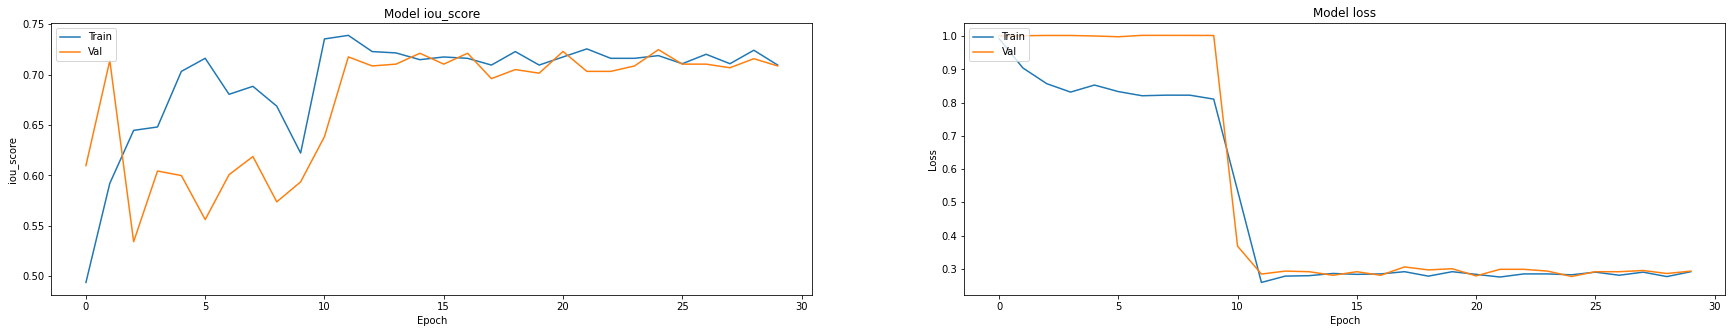

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Model Evaluation

In [ ]:
test_dataloader = DataGenerator(test_set, batch_size=1, shuffle=False)
# load best weights
model.load_weights('best_model.h5') 
scores = model.evaluate_generator(test_dataloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


In [ ]:
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.050442
mean iou_score: 0.94967
mean f1-score: 0.94967


In [32]:
scores = model.evaluate_generator(test_generator)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.18628
mean iou_score: 0.81383
mean f1-score: 0.81383


In [43]:
test_preds = model.predict(test_generator)

In [ ]:
for i in range(5):
  a = np.squeeze(test_preds[i], axis=2)
  plt.imshow(a, cmap='gray')
  plt.show()